In [1]:
import torch
import tqdm
import logger
import numpy as np
import torch.nn as nn
import pickle
import metrics
from skimage import io
from skimage import transform
# from model import FusionNet, DilationCNN, UNet
# from dataset import NucleiDataset, HPADataset, NeuroDataset, HPASingleDataset,get_augmenter
from torch.utils.data import DataLoader
from loss import dice_loss
import imageio


import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

import torchvision
import torchvision.models as tormodel
from torchvision import datasets, transforms
from torchvision.utils import make_grid


import glob
import os
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

def mkdir_if_missing(save_dir):
    if os.path.exists(save_dir):
        return 1
    else:
        os.makedirs(save_dir)
        return 0

# Dataloader

In [2]:
import torch.utils.data as data
from PIL import Image
import os

class GetLoader(data.Dataset):
    def __init__(self, data_root, img_folder, lab_folder, transform=None):
        self.img_root = os.path.join(data_root,img_folder)
        self.mask_root = os.path.join(data_root,lab_folder)
        self.transform = transform
        
        data_list = os.listdir(self.img_root)
        self.n_data = len(data_list)

        self.img_paths = []
        self.lab_paths = []

        for data in data_list:
            self.img_paths.append(os.path.join(self.img_root,data))
            self.lab_paths.append(os.path.join(self.mask_root,data))

    def __getitem__(self, item):
        img_pth, lab_pth = self.img_paths[item], self.lab_paths[item]
        imgs = Image.open(img_pth).convert('RGB')
        labels = np.asarray(imageio.imread(lab_pth))

        if self.transform is not None:
            imgs = self.transform(imgs)
#             labels = self.transform(labels)
        return imgs, labels

    def __len__(self):
        return self.n_data


In [3]:
DATA_DIR = '/home/zhangj41/HW/group_proj/Organ_cyto'
TRAIN_IMG = 'image_train'
TEST_IMG = 'image_test'
TRAIN_MASK = 'mask_train'
TEST_MASK = 'mask_test'

img_transform_train = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
])

'''---train loader---'''
DATASET_TRAIN = GetLoader(
    data_root=DATA_DIR, 
    img_folder=TRAIN_IMG, 
    lab_folder=TRAIN_MASK, 
    transform=img_transform_train
)
DATALOADER_TRAIN = torch.utils.data.DataLoader(
    dataset=DATASET_TRAIN,
    batch_size=50,
    shuffle=True)

'''---test loader---'''
DATASET_TEST = GetLoader(
    data_root=DATA_DIR, 
    img_folder=TEST_IMG, 
    lab_folder=TEST_MASK, 
    transform=img_transform_train
)
DATALOADER_TEST = torch.utils.data.DataLoader(
    dataset=DATASET_TEST,
    batch_size=100,
    shuffle=False)

28


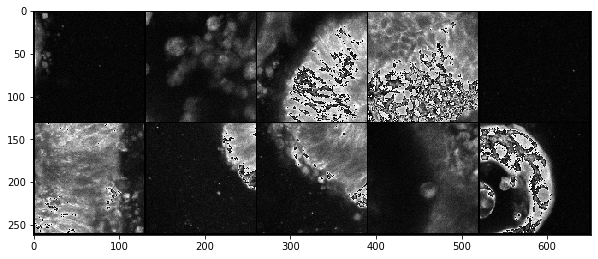

In [4]:
print(len(DATALOADER_TRAIN))
plt.figure(figsize=(10,5))
batch_datas, batch_labels = next(iter(DATALOADER_TRAIN)) 
# print(batch_labels)
img = make_grid(batch_datas[0:10], nrow=5, padding=2)

npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [5]:
# batch_labels_ = batch_labels.unsqueeze(1)
# print(batch_labels_.size())
# img = make_grid(batch_labels_[0:10], nrow=5, padding=2)
# npimg = img.numpy()
# print(npimg.shape)
# plt.imshow(np.transpose(npimg, (1,2,0)), cmap='gray', interpolation='nearest')

In [6]:
batch_label = batch_labels[1]
batch_label.size()

torch.Size([128, 128])

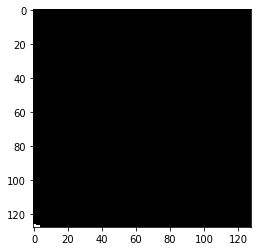

In [7]:
plt.imshow(batch_label, cmap='gray', vmin=0, vmax=1)

# Models

In [8]:
import torch.nn as nn 
import unet_layers as layers


class UNet(nn.Module):
    def __init__(self, num_kernel, kernel_size, dim, target_dim):
        super(UNet, self).__init__()
        self.num_kernel = num_kernel
        self.kernel_size = kernel_size
        self.dim = dim
        self.target_dim = target_dim

        # encode
        self.encode_1 = layers.DownSampling(self.dim, num_kernel, kernel_size)
        self.encode_2 = layers.DownSampling(num_kernel, num_kernel*2, kernel_size)
        self.encode_3 = layers.DownSampling(num_kernel*2, num_kernel*4, kernel_size)
        self.encode_4 = layers.DownSampling(num_kernel*4, num_kernel*8, kernel_size)

        # bridge
        self.bridge = nn.Conv2d(num_kernel*8, num_kernel*16, kernel_size, padding=1, stride=1)

        # decode
        self.decode_4 = layers.UpSampling(num_kernel*16, num_kernel*8, kernel_size)
        self.decode_3 = layers.UpSampling(num_kernel*8, num_kernel*4, kernel_size)
        self.decode_2 = layers.UpSampling(num_kernel*4, num_kernel*2, kernel_size)
        self.decode_1 = layers.UpSampling(num_kernel*2, num_kernel, kernel_size)

        self.segment = nn.Conv2d(num_kernel, self.target_dim, 1, padding=0, stride=1)
        self.activate = nn.Sigmoid()


    def forward(self, x):
        x, skip_1 = self.encode_1(x)
        x, skip_2 = self.encode_2(x)
        x, skip_3 = self.encode_3(x)
        x, skip_4 = self.encode_4(x)

        x = self.bridge(x)

        x = self.decode_4(x, skip_4)
        x = self.decode_3(x, skip_3)
        x = self.decode_2(x, skip_2)
        x = self.decode_1(x, skip_1)

        x = self.segment(x)
        pred = self.activate(x)
        return pred

In [9]:
### debug
# batch_datas, batch_labels = next(iter(dataloader_train)) 
# batch_labels.unsqueeze_(1)
# batch_datas, batch_labels = batch_datas.cuda(), batch_labels.cuda()
# unet = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
# unet.cuda()


In [10]:
# loss_function = dice_loss
# pred = unet(batch_datas)
# print(batch_datas.size(), pred.size(), batch_labels.size())
# loss_function(pred, batch_labels)

In [11]:
# print(torch.min(pred),torch.max(pred))
# print(torch.min(batch_labels),torch.max(batch_labels))

# Utils

## Average meter

In [12]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Cell segmentation

In [13]:
class CellSeg:
    def __init__(self, unet):
        self.unet = unet
        self.unet.cuda()
        self.optimizer = torch.optim.SGD(self.unet.parameters(),
                                         lr=0.01, momentum=0.9, weight_decay=1e-3)
    
    def scheduler(self, epoch, lr0=1e-2):
        lr = lr0
        if epoch >= 20:
            lr = lr0 * 0.1
        if epoch >= 60:
            lr = lr0 * 0.1

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

            
    def train_batch(self,
                    data_loader,
                    epoch):
        '''--- 1. setup network ---'''
        loss_function = dice_loss
#         total_loss = AverageMeter()
#         total_iou = AverageMeter()
#         total_precision = AverageMeter()
        
        # set train state
        self.unet.train()
        len_dataloader = len(data_loader)
        data_iter = iter(data_loader)

        '''--- 2. train network ---'''
        iters=0
        while iters<len_dataloader-1:
            iters+=1
            input_img, class_label = next(data_iter)
            class_label.unsqueeze_(1)
            input_img, class_label = input_img.cuda(), class_label.cuda()
            batch_size = len(class_label)
            '''forward, compute student ce loss'''
            pred_mask = self.unet(input_img)
            loss = loss_function(pred_mask, class_label)
            
            predictions = pred_mask.clone().squeeze().detach().cpu().numpy()
            gt = class_label.clone().squeeze().detach().cpu().numpy()
            ious = [metrics.get_ious(p, g, 0.5) for p,g in zip(predictions, gt)]
            iou_val = np.mean(ious)
            '''backward teacher generate guided-BP map, detach'''
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            if iters%1 == 0:
                print('epoch: {}, [iter {} / all {}], loss:{}, iou:{}'\
                      .format(epoch, iters, len_dataloader, 
                              loss.cpu().data.numpy(),
                              iou_val))
        return loss, iou_val
    
    
    def eval_epoch(self, dataloader):
        cudnn.benchmark = True
        loss_function = dice_loss
        '''---evaluation mode---'''
        self.unet.eval()
        len_dataloader = len(dataloader)
        data_test_iter = iter(dataloader)

        i = 0
        n_total = 0
        n_correct = 0
        total_iou = 0
        total_loss = 0
        total_precision = 0
        counter = 0
#         total_iou = []
        with torch.no_grad():
            while i<len_dataloader:
                # test model using target data
                input_img, class_label = next(data_test_iter)
                class_label.unsqueeze_(1)
                input_img, class_label = input_img.cuda(), class_label.cuda()
                batch_size = len(class_label)

                pred_mask = self.unet(input_img)
                dice_loss_ = loss_function(pred_mask, class_label)
                dice_loss_ = dice_loss_.clone().squeeze().cpu().numpy()
                predictions = pred_mask.clone().squeeze().cpu().numpy()
                gt = class_label.clone().squeeze().cpu().numpy()
                ious = [metrics.get_ious(p, g, 0.5) for p,g in zip(predictions, gt)]
                prec = [metrics.compute_precision(p, g, 0.5) for p,g in zip(predictions, gt)]
#                 total_iou.append(np.mean(ious))
                total_loss += np.sum(dice_loss_)
                total_iou += np.sum(ious)
                total_precision += np.sum(prec)
                counter += batch_size
                i += 1
        iou_avg = total_iou/counter #np.mean(total_iou)
        precision_avg = total_precision/counter
        dice_coeff_avg = 1-total_loss/counter
        print('Normal IOU of the dataset: %f' %(iou_avg))
        print('Normal PREC of the dataset: %f' %(precision_avg))
        print('Normal DICE SCORE of the dataset: %f' %(dice_coeff_avg))
        return iou_avg, precision_avg, dice_coeff_avg
        
        
    def Net_train(self,
                  dl_train,dl_val,
                  n_epochs,
                  save_dir):
        loss_ = []
        iou_val_ = []
        acc_ = []
        for epoch in np.arange(n_epochs):
            # training
            self.scheduler(epoch=epoch)
            loss, iou_val = self.train_batch(data_loader=dl_train,
                                                 epoch=epoch)
            loss_.append(loss)
            iou_val_.append(iou_val)
            # save model
            if epoch>=80:
                file_name = 'unet_epoch'+str(epoch)+'.pth'
                torch.save(self.unet.state_dict(), os.path.join(save_dir,file_name))
            # evaluation
            print('================================================================')
            acc = self.eval_epoch(dataloader=dl_val)
            acc_.append(acc)
            print('================================================================')
        return loss_, iou_val_, acc_

# Main

In [42]:
MODEL_SAVE_PATH = '/home/zhangj41/HW/group_proj/Organ_cyto_models'
mkdir_if_missing(MODEL_SAVE_PATH)

solver = CellSeg(unet=UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1))
loss_, iou_val_, acc_ = solver.Net_train(dl_train=DATALOADER_TRAIN,
                                         dl_val=DATALOADER_TEST,
                                         n_epochs=100,
                                         save_dir=MODEL_SAVE_PATH)

epoch: 0, [iter 1 / all 28], loss:0.7724430561065674, iou:0.07336476445198059
epoch: 0, [iter 2 / all 28], loss:0.7021559476852417, iou:0.11117097735404968
epoch: 0, [iter 3 / all 28], loss:0.6414530277252197, iou:0.17576833069324493
epoch: 0, [iter 4 / all 28], loss:0.7011171579360962, iou:0.12152063101530075
epoch: 0, [iter 5 / all 28], loss:0.6209754943847656, iou:0.15507088035345076
epoch: 0, [iter 6 / all 28], loss:0.7029210329055786, iou:0.12245576828718185
epoch: 0, [iter 7 / all 28], loss:0.6230990290641785, iou:0.184335325807333
epoch: 0, [iter 8 / all 28], loss:0.6488222479820251, iou:0.162626136764884
epoch: 0, [iter 9 / all 28], loss:0.580594539642334, iou:0.18182791113853455
epoch: 0, [iter 10 / all 28], loss:0.6111651659011841, iou:0.16964798817411064
epoch: 0, [iter 11 / all 28], loss:0.614092230796814, iou:0.16468383679166437
epoch: 0, [iter 12 / all 28], loss:0.6768975257873535, iou:0.1578863438218832
epoch: 0, [iter 13 / all 28], loss:0.5668243765830994, iou:0.1671578

epoch: 3, [iter 20 / all 28], loss:0.485887348651886, iou:0.1872899217903614
epoch: 3, [iter 21 / all 28], loss:0.4828728437423706, iou:0.18649274684488773
epoch: 3, [iter 22 / all 28], loss:0.47607266902923584, iou:0.19809969619847834
epoch: 3, [iter 23 / all 28], loss:0.4980905055999756, iou:0.19674801288172603
epoch: 3, [iter 24 / all 28], loss:0.46786177158355713, iou:0.20141600286588074
epoch: 3, [iter 25 / all 28], loss:0.4840471148490906, iou:0.20582181841135025
epoch: 3, [iter 26 / all 28], loss:0.48792606592178345, iou:0.19861031644046306
epoch: 3, [iter 27 / all 28], loss:0.47959983348846436, iou:0.2251798401027918
Normal accuracy of the dataset: 0.216906
epoch: 4, [iter 1 / all 28], loss:0.49592602252960205, iou:0.18749656353145838
epoch: 4, [iter 2 / all 28], loss:0.4301421046257019, iou:0.20344080114737154
epoch: 4, [iter 3 / all 28], loss:0.45969831943511963, iou:0.25094688216224315
epoch: 4, [iter 4 / all 28], loss:0.4869992733001709, iou:0.17566610608249902
epoch: 4, [i

epoch: 7, [iter 8 / all 28], loss:0.4143681526184082, iou:0.25100573187693953
epoch: 7, [iter 9 / all 28], loss:0.4182431101799011, iou:0.23929596468806266
epoch: 7, [iter 10 / all 28], loss:0.45453357696533203, iou:0.2168596202135086
epoch: 7, [iter 11 / all 28], loss:0.4694995880126953, iou:0.20282486587762832
epoch: 7, [iter 12 / all 28], loss:0.4111676812171936, iou:0.23472241684794426
epoch: 7, [iter 13 / all 28], loss:0.43721967935562134, iou:0.1989215697348118
epoch: 7, [iter 14 / all 28], loss:0.45528149604797363, iou:0.20704178154468536
epoch: 7, [iter 15 / all 28], loss:0.4188421964645386, iou:0.22153253749012947
epoch: 7, [iter 16 / all 28], loss:0.49538373947143555, iou:0.1620771468942985
epoch: 7, [iter 17 / all 28], loss:0.480121374130249, iou:0.15145648688077926
epoch: 7, [iter 18 / all 28], loss:0.46054643392562866, iou:0.20519548146054148
epoch: 7, [iter 19 / all 28], loss:0.4630089998245239, iou:0.21420067263767123
epoch: 7, [iter 20 / all 28], loss:0.4440542459487915

epoch: 10, [iter 26 / all 28], loss:0.4289477467536926, iou:0.20352557291742415
epoch: 10, [iter 27 / all 28], loss:0.4185851216316223, iou:0.2136670539015904
Normal accuracy of the dataset: 0.222695
epoch: 11, [iter 1 / all 28], loss:0.4207092523574829, iou:0.19712486431002618
epoch: 11, [iter 2 / all 28], loss:0.42582184076309204, iou:0.20716297900304198
epoch: 11, [iter 3 / all 28], loss:0.4123764634132385, iou:0.22227960677817463
epoch: 11, [iter 4 / all 28], loss:0.38901710510253906, iou:0.23886814668774606
epoch: 11, [iter 5 / all 28], loss:0.39412230253219604, iou:0.22111852258443832
epoch: 11, [iter 6 / all 28], loss:0.3819420337677002, iou:0.2648435039632022
epoch: 11, [iter 7 / all 28], loss:0.4726790189743042, iou:0.22371049627661704
epoch: 11, [iter 8 / all 28], loss:0.4538081884384155, iou:0.20578030455857516
epoch: 11, [iter 9 / all 28], loss:0.42300909757614136, iou:0.24193029866553842
epoch: 11, [iter 10 / all 28], loss:0.41179919242858887, iou:0.18553584367036818
epoch

epoch: 14, [iter 14 / all 28], loss:0.3284805417060852, iou:0.25636785514652727
epoch: 14, [iter 15 / all 28], loss:0.32241302728652954, iou:0.2718925157189369
epoch: 14, [iter 16 / all 28], loss:0.36191636323928833, iou:0.22940255090594291
epoch: 14, [iter 17 / all 28], loss:0.35303735733032227, iou:0.2951781946886331
epoch: 14, [iter 18 / all 28], loss:0.3568248748779297, iou:0.2138523417711258
epoch: 14, [iter 19 / all 28], loss:0.3862701654434204, iou:0.24238284736871718
epoch: 14, [iter 20 / all 28], loss:0.34396809339523315, iou:0.2692877083644271
epoch: 14, [iter 21 / all 28], loss:0.3520321846008301, iou:0.27184839695692065
epoch: 14, [iter 22 / all 28], loss:0.3610476851463318, iou:0.27559522867202757
epoch: 14, [iter 23 / all 28], loss:0.33721256256103516, iou:0.26420481950044633
epoch: 14, [iter 24 / all 28], loss:0.3678252100944519, iou:0.24254752796143295
epoch: 14, [iter 25 / all 28], loss:0.35277247428894043, iou:0.2735633394122124
epoch: 14, [iter 26 / all 28], loss:0.3

epoch: 18, [iter 2 / all 28], loss:0.2768822908401489, iou:0.28582294315099716
epoch: 18, [iter 3 / all 28], loss:0.3046730160713196, iou:0.2512703383434564
epoch: 18, [iter 4 / all 28], loss:0.2689923048019409, iou:0.3028016382455826
epoch: 18, [iter 5 / all 28], loss:0.27695661783218384, iou:0.32765979804098605
epoch: 18, [iter 6 / all 28], loss:0.29330968856811523, iou:0.30618691774085166
epoch: 18, [iter 7 / all 28], loss:0.2720641493797302, iou:0.29726193845272064
epoch: 18, [iter 8 / all 28], loss:0.3002312183380127, iou:0.28608758212067187
epoch: 18, [iter 9 / all 28], loss:0.3004668951034546, iou:0.2720084271207452
epoch: 18, [iter 10 / all 28], loss:0.26448118686676025, iou:0.30943411350250244
epoch: 18, [iter 11 / all 28], loss:0.25863635540008545, iou:0.29448358178138734
epoch: 18, [iter 12 / all 28], loss:0.2719918489456177, iou:0.31683441817760466
epoch: 18, [iter 13 / all 28], loss:0.2963482141494751, iou:0.29811129577457907
epoch: 18, [iter 14 / all 28], loss:0.288410007

epoch: 21, [iter 18 / all 28], loss:0.23855948448181152, iou:0.3645472204685211
epoch: 21, [iter 19 / all 28], loss:0.2488608956336975, iou:0.2519064682722092
epoch: 21, [iter 20 / all 28], loss:0.25225669145584106, iou:0.255085334777832
epoch: 21, [iter 21 / all 28], loss:0.231786847114563, iou:0.36264878548681734
epoch: 21, [iter 22 / all 28], loss:0.2298346757888794, iou:0.35623649388551715
epoch: 21, [iter 23 / all 28], loss:0.21518933773040771, iou:0.40927823185920714
epoch: 21, [iter 24 / all 28], loss:0.22050631046295166, iou:0.44400797262787817
epoch: 21, [iter 25 / all 28], loss:0.21308404207229614, iou:0.3311214739084244
epoch: 21, [iter 26 / all 28], loss:0.23135918378829956, iou:0.3077955734729767
epoch: 21, [iter 27 / all 28], loss:0.2273375391960144, iou:0.4128070503473282
Normal accuracy of the dataset: 0.245738
epoch: 22, [iter 1 / all 28], loss:0.21694058179855347, iou:0.35740150764584544
epoch: 22, [iter 2 / all 28], loss:0.21739351749420166, iou:0.4201404200494289
ep

epoch: 25, [iter 6 / all 28], loss:0.22099924087524414, iou:0.36578438341617586
epoch: 25, [iter 7 / all 28], loss:0.23263275623321533, iou:0.31329904198646547
epoch: 25, [iter 8 / all 28], loss:0.21761447191238403, iou:0.3980061627924442
epoch: 25, [iter 9 / all 28], loss:0.1951717734336853, iou:0.3600022506713867
epoch: 25, [iter 10 / all 28], loss:0.22486448287963867, iou:0.4268788053095341
epoch: 25, [iter 11 / all 28], loss:0.2107669711112976, iou:0.4171433863416314
epoch: 25, [iter 12 / all 28], loss:0.20655184984207153, iou:0.38033381626009943
epoch: 25, [iter 13 / all 28], loss:0.21142369508743286, iou:0.3597686695307493
epoch: 25, [iter 14 / all 28], loss:0.21693462133407593, iou:0.4183481988310814
epoch: 25, [iter 15 / all 28], loss:0.221568763256073, iou:0.35449540950357916
epoch: 25, [iter 16 / all 28], loss:0.21329611539840698, iou:0.3597314327955246
epoch: 25, [iter 17 / all 28], loss:0.2106427550315857, iou:0.3421028208732605
epoch: 25, [iter 18 / all 28], loss:0.2067974

epoch: 28, [iter 22 / all 28], loss:0.19951719045639038, iou:0.36635478734970095
epoch: 28, [iter 23 / all 28], loss:0.2213723063468933, iou:0.3309160542488098
epoch: 28, [iter 24 / all 28], loss:0.20467036962509155, iou:0.35753408193588254
epoch: 28, [iter 25 / all 28], loss:0.21399670839309692, iou:0.44972624465823174
epoch: 28, [iter 26 / all 28], loss:0.20398008823394775, iou:0.36687338501214983
epoch: 28, [iter 27 / all 28], loss:0.1967003345489502, iou:0.34235803842544554
Normal accuracy of the dataset: 0.254787
epoch: 29, [iter 1 / all 28], loss:0.21513617038726807, iou:0.35205665677785875
epoch: 29, [iter 2 / all 28], loss:0.21910184621810913, iou:0.32397990696132184
epoch: 29, [iter 3 / all 28], loss:0.20718127489089966, iou:0.4226493385434151
epoch: 29, [iter 4 / all 28], loss:0.2029484510421753, iou:0.4195704489946365
epoch: 29, [iter 5 / all 28], loss:0.20158612728118896, iou:0.3616034483909607
epoch: 29, [iter 6 / all 28], loss:0.1984877586364746, iou:0.40286667719483377
e

epoch: 32, [iter 10 / all 28], loss:0.2054460048675537, iou:0.31207425236701963
epoch: 32, [iter 11 / all 28], loss:0.20178073644638062, iou:0.3687677145004272
epoch: 32, [iter 12 / all 28], loss:0.18716418743133545, iou:0.42960252583026887
epoch: 32, [iter 13 / all 28], loss:0.1963437795639038, iou:0.3900002268329263
epoch: 32, [iter 14 / all 28], loss:0.20972204208374023, iou:0.338529406785965
epoch: 32, [iter 15 / all 28], loss:0.2033541202545166, iou:0.35997955679893495
epoch: 32, [iter 16 / all 28], loss:0.19111180305480957, iou:0.42806197158992293
epoch: 32, [iter 17 / all 28], loss:0.2050134539604187, iou:0.3810674604773521
epoch: 32, [iter 18 / all 28], loss:0.19476318359375, iou:0.41303762793540955
epoch: 32, [iter 19 / all 28], loss:0.1971801519393921, iou:0.3508604651689529
epoch: 32, [iter 20 / all 28], loss:0.2030789852142334, iou:0.47334652483463285
epoch: 32, [iter 21 / all 28], loss:0.21212798357009888, iou:0.38644756108522416
epoch: 32, [iter 22 / all 28], loss:0.18927

epoch: 35, [iter 26 / all 28], loss:0.20356899499893188, iou:0.3933803673647344
epoch: 35, [iter 27 / all 28], loss:0.23100733757019043, iou:0.28220766097307204
Normal accuracy of the dataset: 0.222580
epoch: 36, [iter 1 / all 28], loss:0.19218909740447998, iou:0.3961705845594406
epoch: 36, [iter 2 / all 28], loss:0.18859368562698364, iou:0.3675961696356535
epoch: 36, [iter 3 / all 28], loss:0.18039357662200928, iou:0.38357745051383974
epoch: 36, [iter 4 / all 28], loss:0.19437211751937866, iou:0.35063142657279966
epoch: 36, [iter 5 / all 28], loss:0.19810009002685547, iou:0.3564130772650242
epoch: 36, [iter 6 / all 28], loss:0.18829751014709473, iou:0.4071790691465139
epoch: 36, [iter 7 / all 28], loss:0.19589656591415405, iou:0.4331735497713089
epoch: 36, [iter 8 / all 28], loss:0.19632607698440552, iou:0.32359611488878726
epoch: 36, [iter 9 / all 28], loss:0.18072330951690674, iou:0.4271312326192856
epoch: 36, [iter 10 / all 28], loss:0.20103472471237183, iou:0.3816149140894413
epoc

epoch: 39, [iter 14 / all 28], loss:0.17585575580596924, iou:0.4330323791503906
epoch: 39, [iter 15 / all 28], loss:0.1987898349761963, iou:0.35087433218955993
epoch: 39, [iter 16 / all 28], loss:0.18321716785430908, iou:0.37213364988565445
epoch: 39, [iter 17 / all 28], loss:0.17749148607254028, iou:0.39345366895198824
epoch: 39, [iter 18 / all 28], loss:0.18536174297332764, iou:0.38215079486370085
epoch: 39, [iter 19 / all 28], loss:0.17770826816558838, iou:0.4006882036477327
epoch: 39, [iter 20 / all 28], loss:0.186174213886261, iou:0.2968267989531159
epoch: 39, [iter 21 / all 28], loss:0.18151432275772095, iou:0.40158345595002176
epoch: 39, [iter 22 / all 28], loss:0.18966037034988403, iou:0.3881028491258621
epoch: 39, [iter 23 / all 28], loss:0.17952674627304077, iou:0.40014005929231644
epoch: 39, [iter 24 / all 28], loss:0.18097400665283203, iou:0.33833164542913435
epoch: 39, [iter 25 / all 28], loss:0.17719942331314087, iou:0.4184026798605919
epoch: 39, [iter 26 / all 28], loss:

epoch: 43, [iter 2 / all 28], loss:0.1825019121170044, iou:0.3961220332235098
epoch: 43, [iter 3 / all 28], loss:0.17992591857910156, iou:0.41286353349685667
epoch: 43, [iter 4 / all 28], loss:0.17869722843170166, iou:0.4723978453874588
epoch: 43, [iter 5 / all 28], loss:0.17109709978103638, iou:0.45715624213218686
epoch: 43, [iter 6 / all 28], loss:0.18292981386184692, iou:0.34248759120702743
epoch: 43, [iter 7 / all 28], loss:0.1728324294090271, iou:0.37432721436023714
epoch: 43, [iter 8 / all 28], loss:0.18245822191238403, iou:0.46190031051635744
epoch: 43, [iter 9 / all 28], loss:0.17042899131774902, iou:0.4490737114846706
epoch: 43, [iter 10 / all 28], loss:0.19774317741394043, iou:0.2770269501954317
epoch: 43, [iter 11 / all 28], loss:0.18553239107131958, iou:0.40852260172367094
epoch: 43, [iter 12 / all 28], loss:0.18755531311035156, iou:0.38636336982250213
epoch: 43, [iter 13 / all 28], loss:0.18442851305007935, iou:0.32079073071479797
epoch: 43, [iter 14 / all 28], loss:0.1727

epoch: 46, [iter 18 / all 28], loss:0.18640154600143433, iou:0.36128760665655135
epoch: 46, [iter 19 / all 28], loss:0.17207562923431396, iou:0.4728365241736174
epoch: 46, [iter 20 / all 28], loss:0.17303228378295898, iou:0.4047458288818598
epoch: 46, [iter 21 / all 28], loss:0.1658979058265686, iou:0.33933780491352084
epoch: 46, [iter 22 / all 28], loss:0.16655564308166504, iou:0.43257353603839876
epoch: 46, [iter 23 / all 28], loss:0.17589318752288818, iou:0.38872781068086626
epoch: 46, [iter 24 / all 28], loss:0.1735292673110962, iou:0.3959292501211166
epoch: 46, [iter 25 / all 28], loss:0.17329663038253784, iou:0.40681631341576574
epoch: 46, [iter 26 / all 28], loss:0.16647058725357056, iou:0.4213508719950914
epoch: 46, [iter 27 / all 28], loss:0.17243081331253052, iou:0.36482734948396683
Normal accuracy of the dataset: 0.240912
epoch: 47, [iter 1 / all 28], loss:0.18157726526260376, iou:0.4379808819293976
epoch: 47, [iter 2 / all 28], loss:0.17316019535064697, iou:0.48328545391559

epoch: 50, [iter 6 / all 28], loss:0.15964233875274658, iou:0.4284272554703057
epoch: 50, [iter 7 / all 28], loss:0.1688612699508667, iou:0.4224422191083431
epoch: 50, [iter 8 / all 28], loss:0.16894149780273438, iou:0.38456050992012025
epoch: 50, [iter 9 / all 28], loss:0.1664048433303833, iou:0.39645802319049833
epoch: 50, [iter 10 / all 28], loss:0.15904724597930908, iou:0.44903233647346497
epoch: 50, [iter 11 / all 28], loss:0.163702130317688, iou:0.4353175142407417
epoch: 50, [iter 12 / all 28], loss:0.1702040433883667, iou:0.432202450633049
epoch: 50, [iter 13 / all 28], loss:0.1643722653388977, iou:0.4361461400985718
epoch: 50, [iter 14 / all 28], loss:0.1543670892715454, iou:0.46611315190792085
epoch: 50, [iter 15 / all 28], loss:0.16376090049743652, iou:0.40589317709207534
epoch: 50, [iter 16 / all 28], loss:0.16098946332931519, iou:0.4158681018650532
epoch: 50, [iter 17 / all 28], loss:0.17157000303268433, iou:0.36947388529777525
epoch: 50, [iter 18 / all 28], loss:0.17086249

epoch: 53, [iter 22 / all 28], loss:0.1549668312072754, iou:0.43016609430313113
epoch: 53, [iter 23 / all 28], loss:0.16334658861160278, iou:0.40557909935712816
epoch: 53, [iter 24 / all 28], loss:0.16467469930648804, iou:0.4073043420910835
epoch: 53, [iter 25 / all 28], loss:0.16103798151016235, iou:0.4063069495558739
epoch: 53, [iter 26 / all 28], loss:0.15578365325927734, iou:0.3635828995704651
epoch: 53, [iter 27 / all 28], loss:0.1697881817817688, iou:0.434617260992527
Normal accuracy of the dataset: 0.222550
epoch: 54, [iter 1 / all 28], loss:0.16301017999649048, iou:0.3861068534851074
epoch: 54, [iter 2 / all 28], loss:0.16932517290115356, iou:0.3456224700063467
epoch: 54, [iter 3 / all 28], loss:0.14959979057312012, iou:0.39725622326135634
epoch: 54, [iter 4 / all 28], loss:0.15120702981948853, iou:0.43951124131679536
epoch: 54, [iter 5 / all 28], loss:0.15711820125579834, iou:0.4643604737520218
epoch: 54, [iter 6 / all 28], loss:0.15442049503326416, iou:0.39587088584899904
epo

epoch: 57, [iter 10 / all 28], loss:0.15476936101913452, iou:0.46206539511680605
epoch: 57, [iter 11 / all 28], loss:0.15104180574417114, iou:0.4099060493707657
epoch: 57, [iter 12 / all 28], loss:0.15911352634429932, iou:0.4328906175494194
epoch: 57, [iter 13 / all 28], loss:0.145757794380188, iou:0.4493535971641541
epoch: 57, [iter 14 / all 28], loss:0.16029608249664307, iou:0.411696303486824
epoch: 57, [iter 15 / all 28], loss:0.145766019821167, iou:0.4391836407035589
epoch: 57, [iter 16 / all 28], loss:0.15996694564819336, iou:0.45370772361755374
epoch: 57, [iter 17 / all 28], loss:0.15400373935699463, iou:0.40345623195171354
epoch: 57, [iter 18 / all 28], loss:0.1593625545501709, iou:0.3978130286931992
epoch: 57, [iter 19 / all 28], loss:0.15857869386672974, iou:0.31968344569206236
epoch: 57, [iter 20 / all 28], loss:0.15576165914535522, iou:0.4638670313358307
epoch: 57, [iter 21 / all 28], loss:0.14653003215789795, iou:0.3683131849765778
epoch: 57, [iter 22 / all 28], loss:0.1502

epoch: 60, [iter 26 / all 28], loss:0.15379202365875244, iou:0.40801867097616196
epoch: 60, [iter 27 / all 28], loss:0.14874809980392456, iou:0.4819076423346996
Normal accuracy of the dataset: 0.210522
epoch: 61, [iter 1 / all 28], loss:0.14789986610412598, iou:0.4954686972498894
epoch: 61, [iter 2 / all 28], loss:0.14492905139923096, iou:0.43383023381233216
epoch: 61, [iter 3 / all 28], loss:0.15224117040634155, iou:0.38944154262542724
epoch: 61, [iter 4 / all 28], loss:0.15740424394607544, iou:0.42097273111343386
epoch: 61, [iter 5 / all 28], loss:0.14313864707946777, iou:0.4387375444173813
epoch: 61, [iter 6 / all 28], loss:0.146983802318573, iou:0.4550745439529419
epoch: 61, [iter 7 / all 28], loss:0.14733028411865234, iou:0.4260463032126427
epoch: 61, [iter 8 / all 28], loss:0.1499847173690796, iou:0.4442545348405838
epoch: 61, [iter 9 / all 28], loss:0.15140289068222046, iou:0.40016927480697634
epoch: 61, [iter 10 / all 28], loss:0.14652109146118164, iou:0.5114091527462006
epoch:

epoch: 64, [iter 14 / all 28], loss:0.1510087251663208, iou:0.4025639474391937
epoch: 64, [iter 15 / all 28], loss:0.13931125402450562, iou:0.4621112018823624
epoch: 64, [iter 16 / all 28], loss:0.16575366258621216, iou:0.4059369593858719
epoch: 64, [iter 17 / all 28], loss:0.15655118227005005, iou:0.3657467359304428
epoch: 64, [iter 18 / all 28], loss:0.18517297506332397, iou:0.3055688378214836
epoch: 64, [iter 19 / all 28], loss:0.14144647121429443, iou:0.4937542860955
epoch: 64, [iter 20 / all 28], loss:0.1457623839378357, iou:0.44391883730888365
epoch: 64, [iter 21 / all 28], loss:0.1514735221862793, iou:0.5225641411542893
epoch: 64, [iter 22 / all 28], loss:0.16635560989379883, iou:0.4385471815615892
epoch: 64, [iter 23 / all 28], loss:0.15085983276367188, iou:0.4939807856082916
epoch: 64, [iter 24 / all 28], loss:0.14742416143417358, iou:0.43389690697193145
epoch: 64, [iter 25 / all 28], loss:0.16733688116073608, iou:0.36142584718763826
epoch: 64, [iter 26 / all 28], loss:0.14836

epoch: 68, [iter 2 / all 28], loss:0.1381588578224182, iou:0.46340986251831057
epoch: 68, [iter 3 / all 28], loss:0.13563966751098633, iou:0.36594275206327437
epoch: 68, [iter 4 / all 28], loss:0.14176678657531738, iou:0.44551984041929243
epoch: 68, [iter 5 / all 28], loss:0.1425129771232605, iou:0.3866101884841919
epoch: 68, [iter 6 / all 28], loss:0.14655965566635132, iou:0.4382209426164627
epoch: 68, [iter 7 / all 28], loss:0.1330854892730713, iou:0.4149220311641693
epoch: 68, [iter 8 / all 28], loss:0.1341649293899536, iou:0.4748369051516056
epoch: 68, [iter 9 / all 28], loss:0.14210689067840576, iou:0.4444922864437103
epoch: 68, [iter 10 / all 28], loss:0.1355772614479065, iou:0.42627893649041654
epoch: 68, [iter 11 / all 28], loss:0.15200358629226685, iou:0.4890545607358217
epoch: 68, [iter 12 / all 28], loss:0.15316808223724365, iou:0.4368676336109638
epoch: 68, [iter 13 / all 28], loss:0.13915038108825684, iou:0.3911886161565781
epoch: 68, [iter 14 / all 28], loss:0.14979588985

epoch: 71, [iter 18 / all 28], loss:0.13786625862121582, iou:0.49513963997364047
epoch: 71, [iter 19 / all 28], loss:0.13091915845870972, iou:0.47603877186775206
epoch: 71, [iter 20 / all 28], loss:0.137942373752594, iou:0.4423008251190186
epoch: 71, [iter 21 / all 28], loss:0.15485447645187378, iou:0.3687122997641563
epoch: 71, [iter 22 / all 28], loss:0.14595067501068115, iou:0.40162719011306763
epoch: 71, [iter 23 / all 28], loss:0.1805475950241089, iou:0.3341787999868393
epoch: 71, [iter 24 / all 28], loss:0.1401156783103943, iou:0.4402795946598053
epoch: 71, [iter 25 / all 28], loss:0.1389368176460266, iou:0.3984214425086975
epoch: 71, [iter 26 / all 28], loss:0.1415533423423767, iou:0.46727252662181856
epoch: 71, [iter 27 / all 28], loss:0.13374513387680054, iou:0.4218167670071125
Normal accuracy of the dataset: 0.218182
epoch: 72, [iter 1 / all 28], loss:0.13534075021743774, iou:0.47272532403469086
epoch: 72, [iter 2 / all 28], loss:0.14435726404190063, iou:0.4222767794132233
ep

epoch: 75, [iter 6 / all 28], loss:0.13135814666748047, iou:0.4425213205814362
epoch: 75, [iter 7 / all 28], loss:0.15726709365844727, iou:0.3413007044792175
epoch: 75, [iter 8 / all 28], loss:0.15044772624969482, iou:0.3761896109580994
epoch: 75, [iter 9 / all 28], loss:0.14112234115600586, iou:0.4060107970237732
epoch: 75, [iter 10 / all 28], loss:0.14142119884490967, iou:0.48716302871704104
epoch: 75, [iter 11 / all 28], loss:0.13277584314346313, iou:0.3686475706100464
epoch: 75, [iter 12 / all 28], loss:0.13719195127487183, iou:0.4785812713205814
epoch: 75, [iter 13 / all 28], loss:0.15342354774475098, iou:0.44738183706998824
epoch: 75, [iter 14 / all 28], loss:0.15611159801483154, iou:0.3703879463672638
epoch: 75, [iter 15 / all 28], loss:0.13719868659973145, iou:0.426391464471817
epoch: 75, [iter 16 / all 28], loss:0.14443618059158325, iou:0.4752980053424835
epoch: 75, [iter 17 / all 28], loss:0.13391900062561035, iou:0.475558393150568
epoch: 75, [iter 18 / all 28], loss:0.136718

epoch: 78, [iter 22 / all 28], loss:0.13210225105285645, iou:0.4124431848526001
epoch: 78, [iter 23 / all 28], loss:0.12934958934783936, iou:0.4852696099877358
epoch: 78, [iter 24 / all 28], loss:0.13354307413101196, iou:0.45544472217559817
epoch: 78, [iter 25 / all 28], loss:0.13257479667663574, iou:0.45733030565083027
epoch: 78, [iter 26 / all 28], loss:0.13393288850784302, iou:0.33134164810180666
epoch: 78, [iter 27 / all 28], loss:0.13235020637512207, iou:0.4821890312433243
Normal accuracy of the dataset: 0.231359
epoch: 79, [iter 1 / all 28], loss:0.12173426151275635, iou:0.5278582310676575
epoch: 79, [iter 2 / all 28], loss:0.1274806261062622, iou:0.42148160576820376
epoch: 79, [iter 3 / all 28], loss:0.1268368363380432, iou:0.3997287340462208
epoch: 79, [iter 4 / all 28], loss:0.13821297883987427, iou:0.3480064517259598
epoch: 79, [iter 5 / all 28], loss:0.12133419513702393, iou:0.5711360251903534
epoch: 79, [iter 6 / all 28], loss:0.1300046443939209, iou:0.42513384491205214
epo

epoch: 82, [iter 10 / all 28], loss:0.13411575555801392, iou:0.4961216652393341
epoch: 82, [iter 11 / all 28], loss:0.12243938446044922, iou:0.4626262772083283
epoch: 82, [iter 12 / all 28], loss:0.13032805919647217, iou:0.4668642831221223
epoch: 82, [iter 13 / all 28], loss:0.13605546951293945, iou:0.4306142967939377
epoch: 82, [iter 14 / all 28], loss:0.14355874061584473, iou:0.3693007957935333
epoch: 82, [iter 15 / all 28], loss:0.12803465127944946, iou:0.4280022120475769
epoch: 82, [iter 16 / all 28], loss:0.12867003679275513, iou:0.4926665896177292
epoch: 82, [iter 17 / all 28], loss:0.1188930869102478, iou:0.4950685477256775
epoch: 82, [iter 18 / all 28], loss:0.12346923351287842, iou:0.48084773689508437
epoch: 82, [iter 19 / all 28], loss:0.12348902225494385, iou:0.5453111550211907
epoch: 82, [iter 20 / all 28], loss:0.12217205762863159, iou:0.4520023062825203
epoch: 82, [iter 21 / all 28], loss:0.124664306640625, iou:0.4147606331110001
epoch: 82, [iter 22 / all 28], loss:0.1361

epoch: 85, [iter 26 / all 28], loss:0.1264525055885315, iou:0.5369978761672973
epoch: 85, [iter 27 / all 28], loss:0.12309825420379639, iou:0.4826232898235321
Normal accuracy of the dataset: 0.231734
epoch: 86, [iter 1 / all 28], loss:0.14351719617843628, iou:0.4203396034240723
epoch: 86, [iter 2 / all 28], loss:0.14047759771347046, iou:0.4705767714977264
epoch: 86, [iter 3 / all 28], loss:0.11408478021621704, iou:0.5066876184940338
epoch: 86, [iter 4 / all 28], loss:0.13153523206710815, iou:0.4110865843296051
epoch: 86, [iter 5 / all 28], loss:0.11876785755157471, iou:0.5166162770986557
epoch: 86, [iter 6 / all 28], loss:0.12402719259262085, iou:0.45063777051866055
epoch: 86, [iter 7 / all 28], loss:0.11857730150222778, iou:0.43367707431316377
epoch: 86, [iter 8 / all 28], loss:0.11413925886154175, iou:0.40175758868455885
epoch: 86, [iter 9 / all 28], loss:0.12153494358062744, iou:0.5224792569875717
epoch: 86, [iter 10 / all 28], loss:0.11720037460327148, iou:0.37937076568603517
epoch

epoch: 89, [iter 14 / all 28], loss:0.12513422966003418, iou:0.3541592502593994
epoch: 89, [iter 15 / all 28], loss:0.1323336362838745, iou:0.5010397851467132
epoch: 89, [iter 16 / all 28], loss:0.12286627292633057, iou:0.46366420269012454
epoch: 89, [iter 17 / all 28], loss:0.13022005558013916, iou:0.45840401530265806
epoch: 89, [iter 18 / all 28], loss:0.13044679164886475, iou:0.5048727262020111
epoch: 89, [iter 19 / all 28], loss:0.11950808763504028, iou:0.5031291830539704
epoch: 89, [iter 20 / all 28], loss:0.12152844667434692, iou:0.46891682505607607
epoch: 89, [iter 21 / all 28], loss:0.1285386085510254, iou:0.5169164806604385
epoch: 89, [iter 22 / all 28], loss:0.11796778440475464, iou:0.48349656119942663
epoch: 89, [iter 23 / all 28], loss:0.140173077583313, iou:0.3628709185123444
epoch: 89, [iter 24 / all 28], loss:0.11567789316177368, iou:0.4387244687974453
epoch: 89, [iter 25 / all 28], loss:0.11705231666564941, iou:0.4714379405975342
epoch: 89, [iter 26 / all 28], loss:0.13

epoch: 93, [iter 2 / all 28], loss:0.12906557321548462, iou:0.4655411019921303
epoch: 93, [iter 3 / all 28], loss:0.11540007591247559, iou:0.469638310149312
epoch: 93, [iter 4 / all 28], loss:0.12040674686431885, iou:0.47320192158222196
epoch: 93, [iter 5 / all 28], loss:0.15302103757858276, iou:0.3843358421325684
epoch: 93, [iter 6 / all 28], loss:0.13652098178863525, iou:0.463997682929039
epoch: 93, [iter 7 / all 28], loss:0.11519443988800049, iou:0.49943011105060575
epoch: 93, [iter 8 / all 28], loss:0.11585468053817749, iou:0.4480132555961609
epoch: 93, [iter 9 / all 28], loss:0.11142688989639282, iou:0.4379601728916168
epoch: 93, [iter 10 / all 28], loss:0.11303281784057617, iou:0.4105684247612953
epoch: 93, [iter 11 / all 28], loss:0.11836707592010498, iou:0.49999020278453826
epoch: 93, [iter 12 / all 28], loss:0.12178760766983032, iou:0.6061045145988464
epoch: 93, [iter 13 / all 28], loss:0.1375335454940796, iou:0.3654797110706568
epoch: 93, [iter 14 / all 28], loss:0.1345437169

epoch: 96, [iter 18 / all 28], loss:0.1190524697303772, iou:0.48813209891319276
epoch: 96, [iter 19 / all 28], loss:0.11067807674407959, iou:0.5022799754142762
epoch: 96, [iter 20 / all 28], loss:0.1138993501663208, iou:0.46479569904506207
epoch: 96, [iter 21 / all 28], loss:0.12643539905548096, iou:0.40476310610771177
epoch: 96, [iter 22 / all 28], loss:0.11641371250152588, iou:0.5262096810340882
epoch: 96, [iter 23 / all 28], loss:0.11037224531173706, iou:0.43957617938518523
epoch: 96, [iter 24 / all 28], loss:0.11782783269882202, iou:0.4771138733625412
epoch: 96, [iter 25 / all 28], loss:0.11212742328643799, iou:0.47907899498939516
epoch: 96, [iter 26 / all 28], loss:0.11442548036575317, iou:0.5209050810337067
epoch: 96, [iter 27 / all 28], loss:0.14064794778823853, iou:0.39442646265029907
Normal accuracy of the dataset: 0.222651
epoch: 97, [iter 1 / all 28], loss:0.11449575424194336, iou:0.40967553317546845
epoch: 97, [iter 2 / all 28], loss:0.11486989259719849, iou:0.4548380899429

Text(0, 0.5, 'loss')

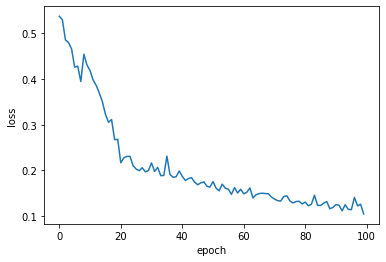

In [43]:
plt.plot(loss_)
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'dice coefficient')

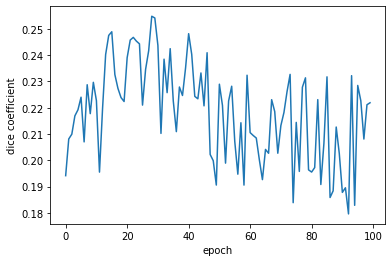

In [44]:
plt.plot(acc_)
plt.xlabel('epoch')
plt.ylabel('dice coefficient')

In [47]:
model_path = '/home/zhangj41/HW/group_proj/Organ_cyto_models/unet_epoch95.pth'
model = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
model = model.cuda()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

28
torch.Size([100, 3, 128, 128]) torch.Size([100, 1, 128, 128]) torch.Size([100, 1, 128, 128])


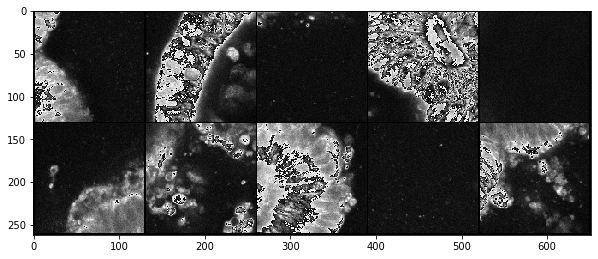

In [48]:
batch_datas, batch_labels = next(iter(DATALOADER_TEST)) 
batch_labels.unsqueeze_(1)

print(len(DATALOADER_TRAIN))
plt.figure(figsize=(10,5))
img = make_grid(batch_datas[0:10], nrow=5, padding=2)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


batch_datas, batch_labels = batch_datas.cuda(), batch_labels.cuda()

pred_masks = model(batch_datas)
print(batch_datas.size(), batch_labels.size(), pred_masks.size())

torch.Size([3, 128, 128])


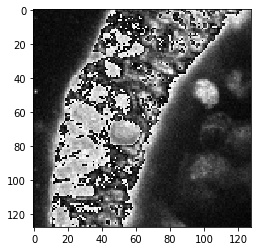

In [49]:
batch_data = batch_datas[1]
print(batch_data.size())
batch_data = batch_data.cpu().data.numpy()
plt.imshow(np.transpose(batch_data, (1,2,0)), cmap='gray', vmin=0, vmax=1)

torch.Size([128, 128])


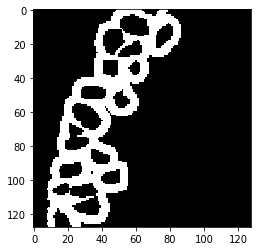

In [50]:
batch_label = batch_labels[1]
batch_label.squeeze_()
print(batch_label.size())
batch_label = batch_label.cpu().data.numpy()
plt.imshow(batch_label, cmap='gray', vmin=0, vmax=1)

torch.Size([128, 128])


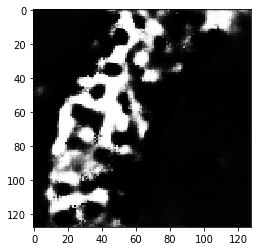

In [51]:
pred_mask = pred_masks[1]
pred_mask.squeeze_()
print(pred_mask.size())
pred_mask = pred_mask.cpu().data.numpy()
plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)

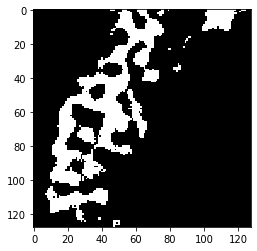

In [52]:
pred_mask[pred_mask>0.5] = 1
pred_mask[pred_mask<=0.5] = 0
plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)

## Metrics

In [14]:
model_path = '/home/zhangj41/HW/group_proj/Organ_cyto_models/unet_epoch95.pth'
model = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
model = model.cuda()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [15]:
solver = CellSeg(unet=model)
iou_avg, precision_avg, dice_coeff_avg = solver.eval_epoch(dataloader=DATALOADER_TEST)

Normal IOU of the dataset: 0.228465
Normal PREC of the dataset: 0.289085
Normal DICE SCORE of the dataset: 0.994966


## Whole image

In [14]:
def img_preprocess(img_dir):
    image = imageio.imread(img_dir).astype("uint8")
    hist, bins = np.histogram(image, bins=256, range=[0,256])
    cum_hist = np.cumsum(hist)
    height, width = image.shape
    norm_cum_hist = cum_hist / (height * width)
    hists_cdf = (norm_cum_hist * 255).astype("uint8")
    # mapping
    img_eq = hists_cdf[image]
    return image
#     plt.imshow(img_eq, cmap='gray', vmin=0, vmax=255)
#     return img_eq

img_transform= transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
])

In [15]:
model_path = '/home/zhangj41/HW/group_proj/Organ_cyto_models/unet_epoch95.pth'
model = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
model = model.cuda()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

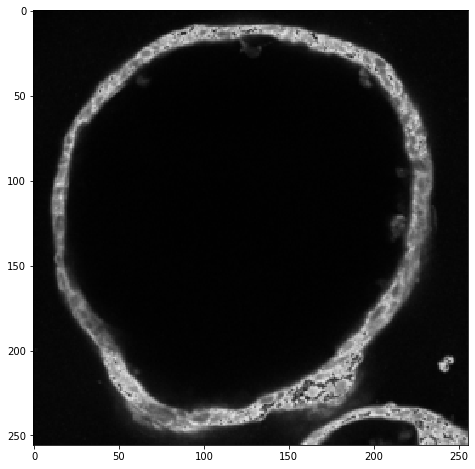

In [16]:
### read the whole image and convert to torch.Tensor
image_loc = '/home/zhangj41/HW/group_proj/Organoids_3D/191120_B6.FCAKPK_Folfox/S1_B6.FCAKPK_Control/S1_B6.FCAKPK_Control 1n_photons.tiff'
image_save = '/home/zhangj41/HW/group_proj/Organoids_3D/191120_B6.FCAKPK_Folfox/S1_B6.FCAKPK_Control/S1_B6.FCAKPK_Control 1n_photons.png'
cell_img = img_preprocess(img_dir=image_loc)
cell_img = Image.fromarray(cell_img)
cell_img.save(image_save)

imgs = Image.open(image_save).convert('RGB')
imgs = img_transform(imgs)

npimg = imgs.numpy()
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

torch.Size([256, 256])


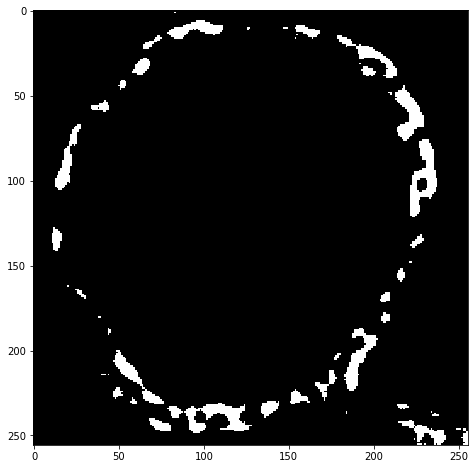

In [17]:
imgs.unsqueeze_(0)
imgs = imgs.cuda()
# imgs.size()

pred_mask = model(imgs)
pred_mask.squeeze_()
print(pred_mask.size())
pred_mask = pred_mask.cpu().data.numpy()
pred_mask[pred_mask>=0.80] = 1
pred_mask[pred_mask<0.80] = 0

plt.figure(figsize=(8, 8))
plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)

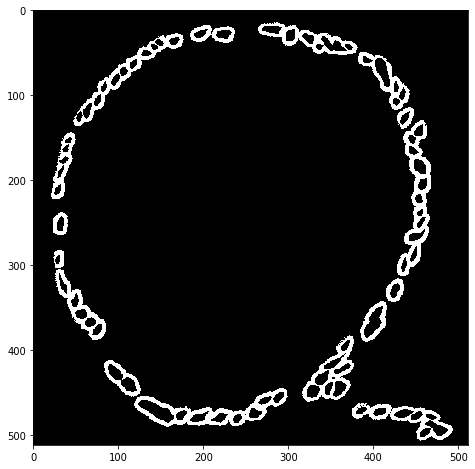

In [18]:
image_loc = '/home/zhangj41/HW/group_proj/Organoids_3D/191120_B6.FCAKPK_Folfox/S1_B6.FCAKPK_Control/Masks/Mask_image_01.tiff'
image = imageio.imread(image_loc).astype("uint8")

image[image>0.5] = 1
image[image<=0.5] = 0

plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray', vmin=0, vmax=1)